In [185]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch_geometric.nn import GCNConv
import networkx as nx
from sklearn.model_selection import train_test_split
from scipy.sparse import csgraph
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.neighbors import kneighbors_graph

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

Get data

In [186]:
# Load the data from the CSV file
data = pd.read_csv('data\\data.csv',skip_blank_lines=False)

# Preprocess the data
locations = []
targets = []
current_locations = []
current_target = []
for _, row in data.iterrows():
    if row.isnull().all():
        if current_locations:
            locations.append(current_locations)
            current_locations = []
        if current_target:
            targets.append(current_target)
            current_target = []
    else:
        current_target.append(row['v'].tolist())
        current_locations.append(row[['x1','x2']].tolist())

# Convert the data into tensors
input_features = [torch.tensor(instance, dtype=torch.float) for instance in locations]
targets = [torch.tensor(instance, dtype=torch.long) for instance in targets]

C:\Users\marti\AppData\Local\Temp\ipykernel_23524\1634795631.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  targets = [torch.tensor(instance, dtype=torch.long) for instance in targets]


In [187]:
# Generate edge_index tensor using k-nearest neighbors
edge_indices = []
k = 5 # Number of nearest neighbors

for i,instance in enumerate(locations):
    instance_tensor = torch.tensor(instance, dtype=torch.float)
    adjacency_matrix = kneighbors_graph(instance_tensor, k, mode='connectivity', include_self=False).tocoo()
    edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)
    edge_indices.append(edge_index)
    # Calculate sparsity of the graph
    num_nodes = instance_tensor.shape[0]
    num_edges = adjacency_matrix.nnz
    sparsity = num_edges / (num_nodes * num_nodes)
    # print(f"Instance {i + 1} sparsity: {sparsity:.4f}")

# Split data into training and testing sets
input_train, input_test, target_train, target_test, edge_train, edge_test = train_test_split(
    input_features, targets, edge_indices, test_size=0.7, random_state=42
)

Instance 0 sparsity: 0.1020


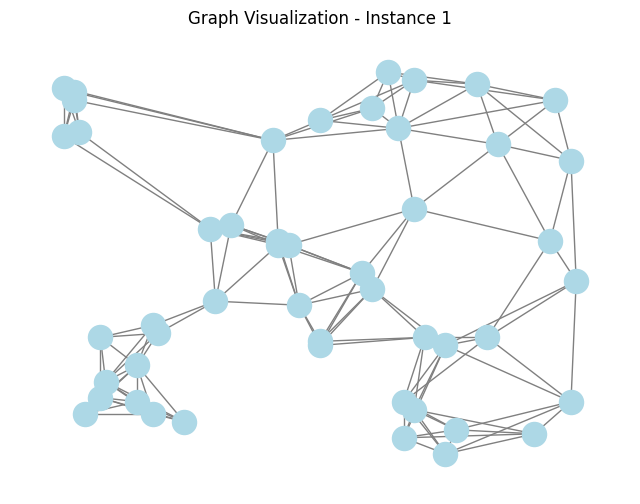

In [188]:
# visualize one of the graphs
# Select an instance to visualize
instance_index = 0
instance = locations[instance_index]
instance_tensor = torch.tensor(instance, dtype=torch.float)
edge_index = kneighbors_graph(instance_tensor, n_neighbors=k, mode='connectivity', include_self=False).tocoo()
num_nodes = instance_tensor.shape[0]
num_edges = edge_index.nnz
sparsity = num_edges / (num_nodes * num_nodes)
print(f"Instance {instance_index} sparsity: {sparsity:.4f}")
# Create a NetworkX graph
graph = nx.Graph()
graph.add_edges_from(zip(edge_index.row, edge_index.col))

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(graph, pos={i: loc for i, loc in enumerate(instance)}, node_color='lightblue', edge_color='gray', with_labels=False)
plt.title(f"Graph Visualization - Instance {instance_index+1}")
plt.axis('off')
plt.show()

In [189]:
# Define GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim[0])
        self.conv2 = GCNConv(hidden_dim[0], hidden_dim[1])
        self.fc = nn.Linear(hidden_dim[1], output_dim)  # Adjust output size based on your problem

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for data in data_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)
        
def evaluate(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            loss = criterion(output, data.y)
            epoch_loss += loss.item()

    return epoch_loss / len(test_loader)

In [190]:
input_dim = 2  # Dimensionality of input features (location coordinates)
hidden_dim = [64,32]  # Dimensionality of hidden layers
output_dim = 5  # Number of vehicles

batch_size = 64

model = GNN(input_dim, hidden_dim, output_dim)

# Train the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_data = [Data(x=feature, y=target, edge_index=edge) for feature, target, edge in zip(input_train, target_train, edge_train)]
train_loader = DataLoader(train_data, batch_size=batch_size)
test_data = [Data(x=feature, y=target, edge_index=edge) for feature, target, edge in zip(input_test, target_test, edge_test)]
test_loader = DataLoader(test_data, batch_size=batch_size)

num_epochs = 200
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

c:\Users\marti\anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


check model performance

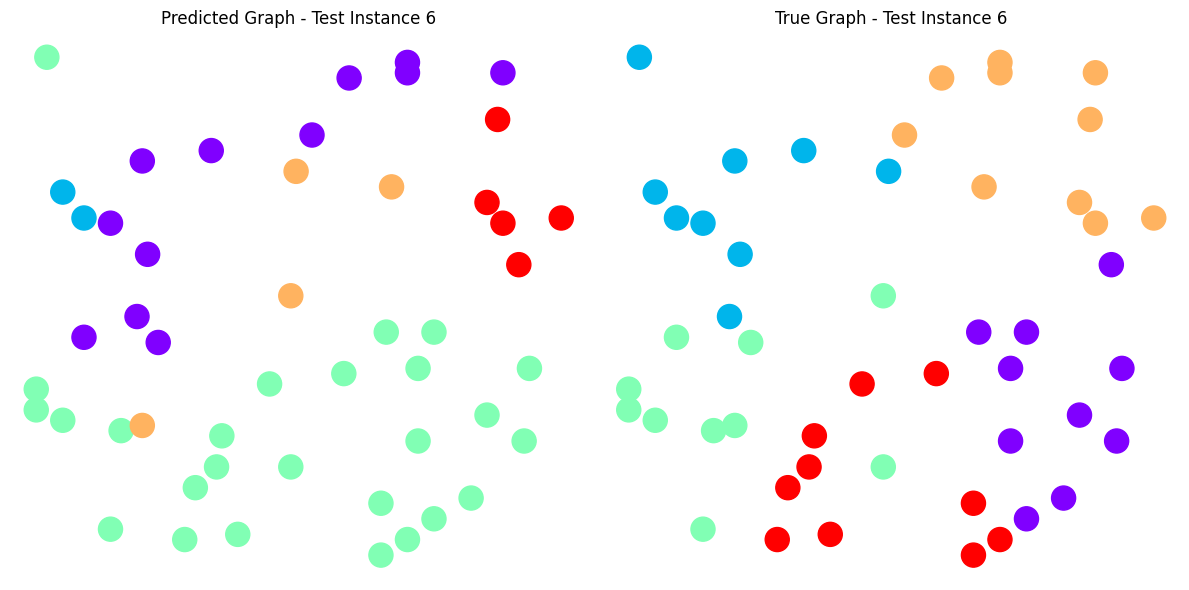

In [192]:
# Select a test instance to visualize
test_instance_index = 5
test_instance = test_loader.dataset[test_instance_index]

# Get the predicted output for the test instance
with torch.no_grad():
    predicted_output = model(test_instance)

# Reshape the predicted output for visualization
predicted_classes = predicted_output.argmax(dim=1)

# Get the corresponding test Data object
test_instance_data = test_data[test_instance_index]

# Extract the features, target, and edge index from the Data object
test_features = test_instance_data.x
test_target = test_instance_data.y
test_edge_index = test_instance_data.edge_index

# Create a NetworkX graph
graph = nx.Graph()
num_nodes = test_features.size(0)
graph.add_nodes_from(range(num_nodes))
# graph.add_edges_from(zip(test_edge_index[0].tolist(), test_edge_index[1].tolist()))

# Get the positions of the nodes from test_instance.x
node_positions = test_features[:, :2].tolist()  # Assuming the first two columns of test_features are the positions

# Plot the graph with node colors representing the predicted classes

# Plot the predicted graph with node colors representing the predicted classes
predicted_node_colors = predicted_classes.tolist()
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw_networkx(graph, pos=dict(enumerate(node_positions)), node_color=predicted_node_colors, cmap='rainbow', with_labels=False)
plt.title(f"Predicted Graph - Test Instance {test_instance_index+1}")
plt.axis('off')

# Plot the true graph with node colors representing the true classes
true_node_colors = test_target.tolist()
plt.subplot(122)
nx.draw_networkx(graph, pos=dict(enumerate(node_positions)), node_color=true_node_colors, cmap='rainbow', with_labels=False)
plt.title(f"True Graph - Test Instance {test_instance_index+1}")
plt.axis('off')

plt.tight_layout()
plt.show()
